In [3]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
basepath = Path('D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton')
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()
cur_dir = Path(os.getcwd())

# Get Data Directory
root = tk.Tk()
root.withdraw()


if cur_system == "Linux":  # For Linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path
    # Directories 

elif cur_system == "Windows":
    sys.path.extend(['C:\\BrianKim\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    
    cur_folder = Path(basepath).name
    session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)
    save_dir = Path('D:\Analyses\Preliminary')

save_dir = Path(save_dir / cur_folder)
plot_dir = Path(save_dir / 'Plots')

save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print(cur_system)
print(basepath)
print(cur_folder)
print(session_name)
print(save_dir)
print(plot_dir)

Windows
D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton
Stb_2024-10-29_Bridgehampton
Stb_Bridgehampton
D:\Analyses\Preliminary\Stb_2024-10-29_Bridgehampton
D:\Analyses\Preliminary\Stb_2024-10-29_Bridgehampton\Plots


In [5]:
# Import NeuroPy Packages

# Analyses
from neuropy.analyses import oscillations
from neuropy.analyses.spkepochs import detect_pbe_epochs

# Core
from neuropy import core

from neuropy.core import Epoch
from neuropy.core import Neurons
from neuropy.core.neurons import binned_pe_raster
from neuropy.core.neurons import pe_raster

from neuropy.core import BinnedSpiketrain
from neuropy.core import Shank, Probe, ProbeGroup

from neuropy.core.session import ProcessData

# IO
from neuropy.io import PhyIO

from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.io.openephysio import load_all_ttl_events

# Plotting
from neuropy.plotting import plot_probe
from neuropy.plotting import Fig
from neuropy.plotting import spikes

from neuropy.plotting.signals import plot_signal_traces

# Utils

from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.utils.signal_process import filter_sig

In [6]:
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

signal = sess.eegfile.get_signal()
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')

filename: D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3534.55 seconds 
duration: 0.98 hours 

Existing artifact epochs file loaded


D:\Data\PCDisruption\Pre\Strawberry\Stb_2024-10-29_Bridgehampton\Stb_Bridgehampton.probegroup.npy saved


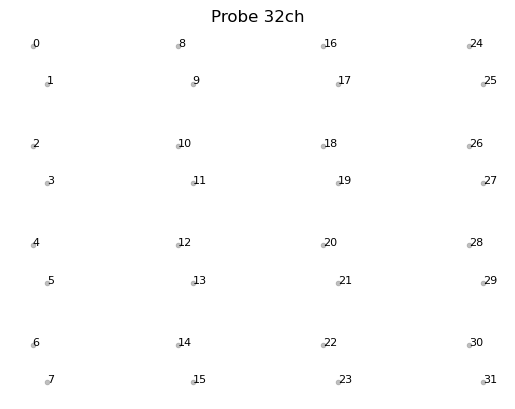

In [7]:
# Set Probe Configuration
shanks = []
channel_groups = sess.recinfo.channel_groups

for i in range(4):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=4,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]),
    )
    shanks.append(shank)
    #shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks,shank_pitch=(150,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
plot_probe(prbgrp)
sess.prbgrp = prbgrp


In [129]:
# Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

for sh in np.unique(sess.neurons.shank_ids.astype(int)):
    sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [9]:
stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")


stim_epochs = Epoch(epochs=None, file=stim_epochs_file)
stim_epochs_df = stim_epochs.to_dataframe()
pd.set_option('display.max_rows', None)

# Session specific code
stim_epochs_df = stim_epochs_df.drop(index=0)
stim_epochs_df = stim_epochs_df.reset_index(drop=True)

stim_epochs_df

,start,stop,duration,time_between,label
0,503.167633,503.217633,0.050000,42.758300,
1,503.255700,503.305700,0.050000,0.038067,
2,503.348633,503.398633,0.050000,0.042933,
3,503.459633,503.509633,0.050000,0.061000,
4,503.549700,503.599700,0.050000,0.040067,
5,503.660000,503.710000,0.050000,0.060300,
6,503.751767,503.801767,0.050000,0.041767,
7,503.846733,503.896700,0.049967,0.044967,
8,503.954833,504.004833,0.050000,0.058133,
9,504.048333,504.098333,0.050000,0.043500,


In [10]:
final_test_stim = 188
test_stim_epochs_df = stim_epochs_df.head(final_test_stim).copy()

s_label = []
total_stims = test_stim_epochs_df.shape[0]
t_num = 1

s_label.append(t_num)

for i in range(1, total_stims):
    if test_stim_epochs_df.loc[i,'time_between'] > 1:
        t_num = t_num + 1
    s_label.append(t_num)
test_stim_epochs_df['label'] = pd.Series(s_label)

# Split epochs into stim events
t_starts = test_stim_epochs_df.groupby('label')['start'].first().to_numpy()
test_stim_epochs_df

,start,stop,duration,time_between,label
0,503.167633,503.217633,0.050000,42.758300,1
1,503.255700,503.305700,0.050000,0.038067,1
2,503.348633,503.398633,0.050000,0.042933,1
3,503.459633,503.509633,0.050000,0.061000,1
4,503.549700,503.599700,0.050000,0.040067,1
5,503.660000,503.710000,0.050000,0.060300,1
6,503.751767,503.801767,0.050000,0.041767,1
7,503.846733,503.896700,0.049967,0.044967,1
8,503.954833,504.004833,0.050000,0.058133,1
9,504.048333,504.098333,0.050000,0.043500,1


It is advisable to use this estimation across multiple neurons object


C:\BrianKim\Code\Repositories\NeuroPy\neuropy\utils\neurons_util.py:126: RuntimeWarning: invalid value encountered in divide
  mean_isi = np.sum(acgs_right * t_ccg_right, axis=1) / np.sum(acgs_right, axis=1)
C:\Users\bkimq\.conda\envs\NeuroPy\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


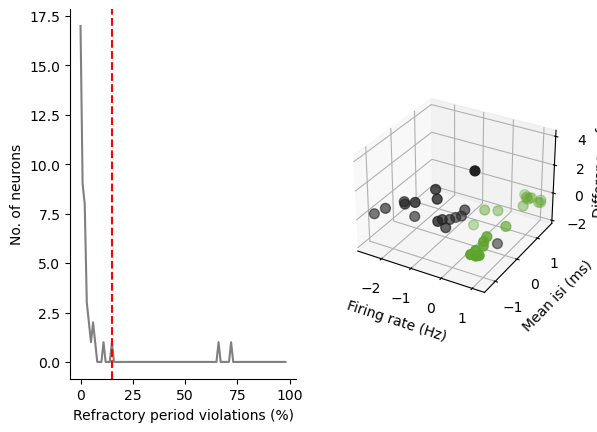

In [11]:
ce_classification = neurons_util.estimate_neuron_type(sess.neurons, mua_thresh=15)
ce_classification = ce_classification[0]

In [28]:
for i in range(0, len(sess.neurons)):
    
    # Test for 20hz pulse plot
    b_size = 0.25
    pulse_dur = 0.05
    pulse_freq = 10
    pulse_int = 1 / pulse_freq  # Time between the start of each pulse
    sid = int(sess.neurons.shank_ids[i])
    
    if sess.neurons.clu_q[i] <= 3:
        c_class = "pyr"
    elif sess.neurons.clu_q[i] == 6:
        c_class = "mua"
    elif sess.neurons.clu_q[i] == 8:
        c_class = "int"
    else:
        c_class = "noise"
    
    pulse_plot, ax = plt.subplots(1,1)
    pulse_plot.set_size_inches([12,6]) # Adjust the width and height to make it wider
    
    # Create Pulse Plot
    t_cell = pe_raster(neurons=sess.neurons, neuron_id=i, event_times=t_starts, buffer_sec=(1,2))
    spikes.plot_raster(t_cell, ax=ax, markersize=6)
    
    
    # Add blue shaded regions from 0s to 1s to indicate optogenetic pulses
    for start_time in range(pulse_freq):
        pulse_start = start_time * pulse_int
        pulse_end = pulse_start + pulse_dur
        ax.axvspan(pulse_start, pulse_end, color='blue', alpha=0.2)

    # Add title
    plt.suptitle(f'Cell {i} (Loc: S{sid}) 10Hz Stims', fontsize=14, y=1.05)
    ax.set_ylabel("Trials")
    
    ax1 = ax.twinx()
    
    
    t_fr = t_cell.get_binned_spiketrains(bin_size=b_size)
    t_binned_averages = t_fr.spike_counts.mean(axis=0)
    t_binned_stds = t_fr.spike_counts.std(axis=0)
    n_trials = t_fr.spike_counts.shape[0]
    t_binned_sems = t_binned_stds / np.sqrt(n_trials)
    
    x_values = np.linspace(-1, 2, len(t_binned_averages))
    ax1.plot(x_values, t_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax1.set_ylabel('Firing Rate(Hz)')
    ax1.set_ylim(0, 30) 
    ax1.fill_between(x_values, t_binned_averages - t_binned_sems, t_binned_averages + t_binned_sems, color='red', alpha=0.3)
    
    
    pulse_plot.text(0.65, 0.93, f'Cell Classification: {ce_classification[i]}', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    ax1.legend()
    ax1.legend(loc='upper left', bbox_to_anchor=(0,1.35))
    
    
    
    plot_name = f'PulseStim_Cell_{i}_S{sid}.png' 
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

In [108]:
# Initialize lists to store the results
stim_on_start = []
stim_on_stop = []
stim_off_start = []
stim_off_stop = []

# Iterate over the DataFrame rows to calculate stim on and stim off times
for i in range(len(stim_epochs_df)):
    # Stim on times
    stim_on_start.append(stim_epochs_df.loc[i, 'start'])
    stim_on_stop.append(stim_epochs_df.loc[i, 'stop'])
    
    # Calculate the proposed stim off start and stop times
    stim_off_start_time = stim_epochs_df.loc[i, 'stop']
    stim_off_stop_time = stim_off_start_time + 0.050
    
    # Check if the next stim-on time interferes with the stim-off period
    if i < len(stim_epochs_df) - 1 and stim_epochs_df.loc[i + 1, 'start'] < stim_off_stop_time:
        # If there's interference, limit the stim off stop time to the start of the next stim-on
        stim_off_stop_time = stim_epochs_df.loc[i + 1, 'start']
    
    # Append calculated stim-off start and stop times
    stim_off_start.append(stim_off_start_time)
    stim_off_stop.append(stim_off_stop_time)

# Construct the resulting DataFrame
result_df = pd.DataFrame({
    'stim_on_start': stim_on_start,
    'stim_on_stop': stim_on_stop,
    'stim_off_start': stim_off_start,
    'stim_off_stop': stim_off_stop
})

stim_on_df = pd.DataFrame({
    'start': stim_on_start,
    'stop': stim_on_stop,
    'label': ''
})

stim_on = Epoch(stim_on_df)

stim_off_df = pd.DataFrame({
    'start': stim_off_start,
    'stop': stim_off_stop,
    'label': ''
})

stim_off = Epoch(stim_off_df)



t_stim_on_start = stim_on_df.start.to_numpy()

In [225]:
for i in range(0, len(sess.neurons)):
    sid = int(sess.neurons.shank_ids[i])
    stim_delta_plot, ax = plt.subplots(1,2)
    test_cell = pe_raster(neurons=sess.neurons, neuron_id=i, event_times=t_stim_on_start, buffer_sec=(0,0.09))
    spikes.plot_raster(test_cell, ax=ax[0], markersize=2)
    stim_delta_plot.set_size_inches([12,6]) # Adjust the width and height to make it wider
    
    test_fr = test_cell.get_binned_spiketrains(bin_size=0.01)
    test_binned_averages = test_fr.spike_counts.mean(axis=0) / 0.1
    test_binned_stds = test_fr.spike_counts.std(axis=0)
    n_trials = test_fr.spike_counts.shape[0]
    test_binned_sems = test_binned_stds / np.sqrt(n_trials)
    ax[0].set_ylabel("Trials")

    ax[0].axvspan(0, 0.05, color='blue', alpha=0.2)

    ax1 = ax[0].twinx()
    x_values = np.linspace(0, 0.1, len(test_binned_averages))
    ax1.plot(x_values, test_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax1.set_ylabel('Firing Rate(Hz)')
    ax1.set_ylim(0, 30) 
    ax1.fill_between(x_values, test_binned_averages - test_binned_sems, test_binned_averages + test_binned_sems, color='red', alpha=0.3)
    
    # Add title
    plt.suptitle(f'Cell {i} (Loc: S{sid}) On/Off Comparison', fontsize=14, y=1.05)
    
    cur_neuron = sess.neurons.neuron_slice(neuron_inds=[i])
    stim_on_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_on)
    stim_off_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_off)
    
    get_spike_count = stim_on_neurons.get_spikes_in_epochs(epochs=stim_on, bin_size=0.001)
    get_spike_count_off = stim_off_neurons.get_spikes_in_epochs(epochs=stim_off, bin_size=0.001)
    
    spk_count = np.array([np.sum(arr) for arr in get_spike_count[0]])
    spk_count_off = np.array([np.sum(arr) for arr in get_spike_count_off[0]])
    
    spk_count_plt = [spk_count * 2, spk_count_off * 2]
    
    spk_freq = spk_count / 0.05
    spk_freq_off = spk_count_off / 0.05
    
    ax[1].boxplot(spk_count_plt, tick_labels=['Stim On', 'Stim Off'], vert=True)
    ax[1].set_title("Boxplot")
    ax[1].set_ylabel("Firing Rate (Hz)")
    plt.subplots_adjust(wspace=0.4)  # Increase wspace as needed

    stim_delta_plot.text(0.65, 0.93, f'Cell Classification: {ce_classification[i]}', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    ax1.legend()
    ax1.legend(loc='upper left', bbox_to_anchor=(0,1.35))
    
    plot_name = f'OnOffComp_Cell_{i}_S{sid}.png' 
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

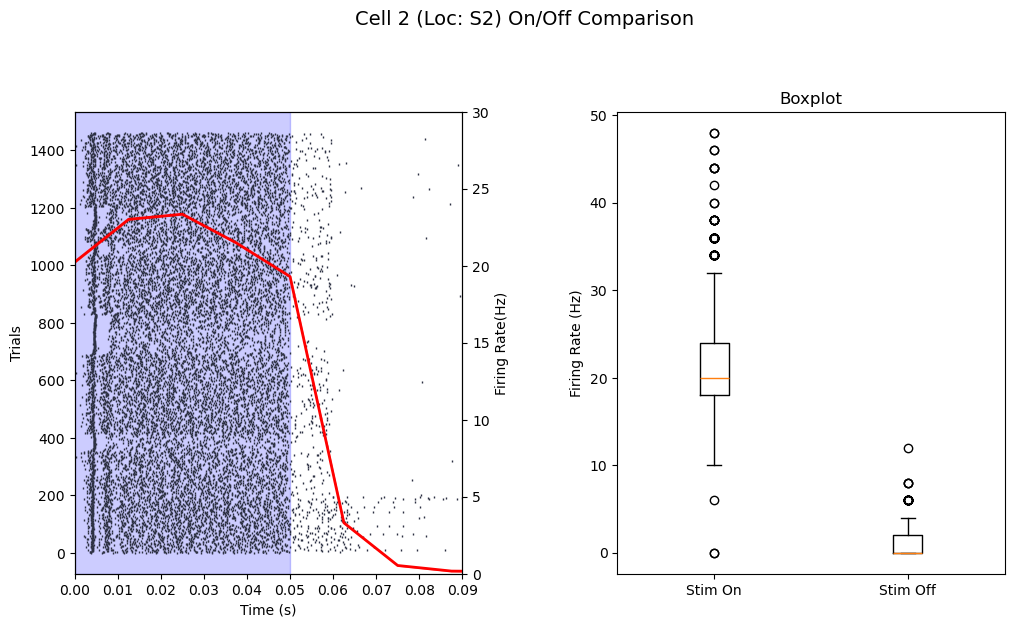

In [222]:
i = 2
sid = int(sess.neurons.shank_ids[i])
stim_delta_plot, ax = plt.subplots(1,2)
test_cell = pe_raster(neurons=sess.neurons, neuron_id=i, event_times=t_stim_on_start, buffer_sec=(0,0.09))
spikes.plot_raster(test_cell, ax=ax[0], markersize=2)
stim_delta_plot.set_size_inches([12,6]) # Adjust the width and height to make it wider

test_fr = test_cell.get_binned_spiketrains(bin_size=0.01)
test_binned_averages = test_fr.spike_counts.mean(axis=0) / 0.1
test_binned_stds = test_fr.spike_counts.std(axis=0)
n_trials = test_fr.spike_counts.shape[0]
test_binned_sems = test_binned_stds / np.sqrt(n_trials)
ax[0].set_ylabel("Trials")
ax1 = ax[0].twinx()
x_values = np.linspace(0, 0.1, len(test_binned_averages))
ax1.plot(x_values, test_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
ax1.set_ylabel('Firing Rate(Hz)')
ax1.set_ylim(0, 30) 
ax1.fill_between(x_values, test_binned_averages - test_binned_sems, test_binned_averages + test_binned_sems, color='red', alpha=0.3)
ax[0].axvspan(0, 0.05, color='blue', alpha=0.2)
# Add title
plt.suptitle(f'Cell {i} (Loc: S{sid}) On/Off Comparison', fontsize=14, y=1.05)

cur_neuron = sess.neurons.neuron_slice(neuron_inds=[i])
stim_on_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_on)
stim_off_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_off)

get_spike_count = stim_on_neurons.get_spikes_in_epochs(epochs=stim_on, bin_size=0.001)
get_spike_count_off = stim_off_neurons.get_spikes_in_epochs(epochs=stim_off, bin_size=0.001)

spk_count = np.array([np.sum(arr) for arr in get_spike_count[0]])
spk_count_off = np.array([np.sum(arr) for arr in get_spike_count_off[0]])

spk_count_plt = [spk_count * 2, spk_count_off * 2]

spk_freq = spk_count / 0.05
spk_freq_off = spk_count_off / 0.05

ax[1].boxplot(spk_count_plt, tick_labels=['Stim On', 'Stim Off'], vert=True)
ax[1].set_title("Boxplot")
ax[1].set_ylabel("Firing Rate (Hz)")
plt.subplots_adjust(wspace=0.4)  # Increase wspace as needed


In [209]:
cur_neuron = sess.neurons.neuron_slice(neuron_inds=[i])
stim_on_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_on)
get_spike_count = stim_on_neurons.get_spikes_in_epochs(epochs=stim_on, bin_size=0.001)
spk_count = np.array([np.sum(arr) for arr in get_spike_count[0]])
spk_freq = spk_count / 0.05
spk_freq

array([360., 320., 260., ..., 180., 160., 140.])

In [ ]:
stim_on_neurons = cur_neuron.get_neurons_in_epochs(epochs=stim_on)
test = stim_on_neurons.get_spikes_in_epochs(epochs=stim_on, bin_size=0.05)
spikes_stim_on = [arr if arr.size > 0 else np.array([[0]]) for arr in test[0]]
total_sum_spikes_stim_on = np.sum(spikes_stim_on)
total_sum_spikes_stim_on / ( 0.05 * 1461)

45.17453798767967

In [192]:
df = stim_on_df.head(5)
test = Epoch(df)

cur_neuron = sess.neurons.neuron_slice(neuron_inds=[i])
stim_on_neuron = cur_neuron.get_neurons_in_epochs(epochs=test)
get_spike_count = stim_on_neurons.get_spikes_in_epochs(epochs=test, bin_size=0.001)

In [197]:
sums_per_array = [np.sum(arr) for arr in get_spike_count[0]]
sums_per_array

[18, 16, 13, 12, 10]